## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from ShapeInspectorGUI import runGUI, allDataC
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd
from pathlib import Path

## Load dataset

In [4]:
path = Path().cwd()
data_file = path.parent / "Week_8" / "Data" / "faces.csv"
# This file might end up somewhere else
con_file = path.parent / "Week_8" / "Data" / "conlist.csv"

X = np.loadtxt(data_file, delimiter =",")
conlist = np.loadtxt(con_file, delimiter = ",").astype(int)
# Conlist is stupid and made with "only" matlab in mind, retract 1 to start from 0
conlist[:,0:2] -= 1

n, p = np.shape(X)

## Helper functions

In [5]:
def drawShape(mu, conlist, title="Mean face"):
   # Matlabs drawshape is a strange un-intuative function, here's how you do it
   for i in range(np.size(conlist, axis = 0)): # How many different lines exist in the data (7)
       xpoints = mu[conlist[i,0]:conlist[i,1]+1]
       ypoints = mu[conlist[i,0] +  58:conlist[i,1] + 59]
       
       if conlist[i][2] == 1: # If it is a closed loop
           xpoints = np.append(xpoints, xpoints[0])
           ypoints = np.append(ypoints, ypoints[0])
       plt.plot(xpoints, ypoints, color = "b")
   plt.title(title)
   plt.axis('equal')
   plt.show()

In [6]:
def drawShapeSubPlot(mu, conlist, ax, label, color = "b"):
    # Matlabs drawshape is a strange un-intuative function, here's how you do it
    for i in range(np.size(conlist, axis = 0)): # How many different lines exist in the data (7)
        xpoints = mu[conlist[i,0]:conlist[i,1]+1]
        ypoints = mu[conlist[i,0] +  58:conlist[i,1] + 59]
        
        if conlist[i][2] == 1: # If it is a closed loop
            xpoints = np.append(xpoints, xpoints[0]) 
            ypoints = np.append(ypoints, ypoints[0])
        ax.plot(xpoints, ypoints, color = color, label = label)
    ax.axis('equal')

In [7]:
""" See https://en.wikipedia.org/wiki/Talk:Varimax_rotation for method"""
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p, k = Phi.shape
    R = np.eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = np.dot(Phi, R)
        u,s,vh = svd(np.dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T,Lambda))))))
        R = np.dot(u,vh)
        d = np.sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return np.dot(Phi, R)

## 2 Extract Sparse Principal Components for the face data using three different methods:
> a) Compute a sparse PCA by thresholding all loadings from a regular PCA with absolute value less than 0.15. Now that the loading matrix has been changed, the scores matrix must be recomputed. How can you use this new scores matrix to compute the variance of the data along each principal axis? Use this result to plot the first mode of variation of the threshold SPCA for -2.5, 0 and +2.5 standard deviations. Investigate what has happened with the uncorrelatedness of the loadings and scores matrices of regular PCA. Are these properties fulfilled here?

In [8]:
# calculate mean of data
mu = np.mean(X, axis = 0) # mean of each column (each variable)
# center the data
Xc = X - np.ones((n,1))*mu # center the data by subtracting the mean

# get scores and loadings. Remember to compensate for the different ordering of the returned V from svd
U, d, V = svd(Xc) # singular value decomposition

# calculate the variances
sigma2 = d**2/n

# keep only modes correspoding to strictly positive singular values
d = d[np.where(d > 1e-9)]
stop = len(d)

# Obtain the final scores and loadings
S = U[:, :stop] @ np.diag(d)  # scores (vectors) 
L = V.T[:, :stop]# loadings (values)

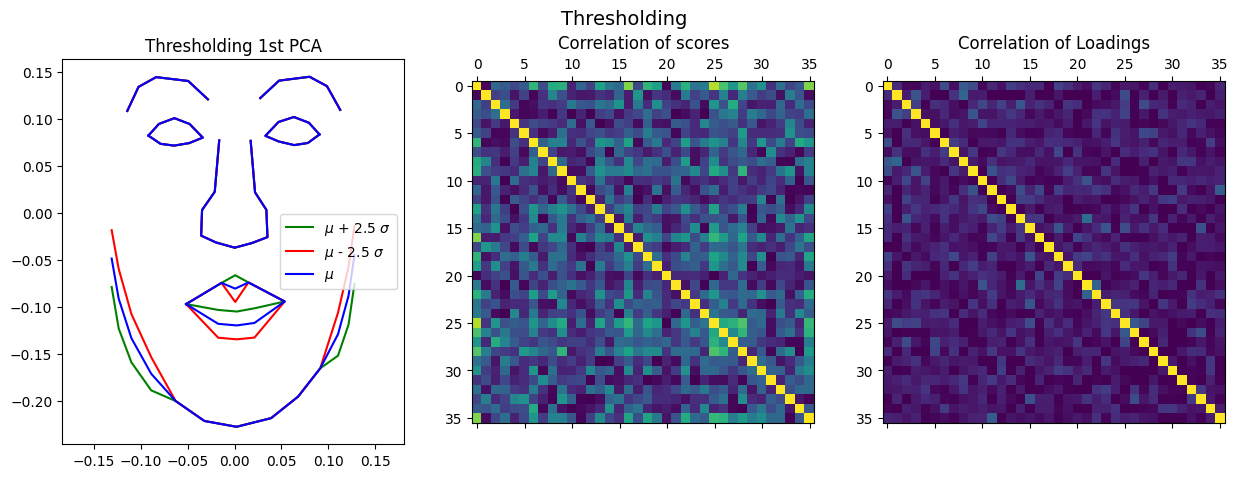

In [9]:
# apply thresholding to the loading matrix
Lthres = L
Lthres[np.where(np.abs(L) < 0.15)] = 0 
Sthres = Xc @ Lthres
sigma2thres = np.var(Sthres, axis = 0) # variance of the scores

# use the drawshape to inspect the resulting face
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("Thresholding", fontsize=14)
drawShapeSubPlot(mu.T + 2.5 * np.sqrt(sigma2thres[0]) * Lthres[:, 0], conlist, ax[0], "$\mu$ + 2.5 $\sigma$", "g")
drawShapeSubPlot(mu.T - 2.5 * np.sqrt(sigma2thres[0]) * Lthres[:, 0], conlist, ax[0], "$\mu$ - 2.5 $\sigma$", "r")
drawShapeSubPlot(mu, conlist, ax[0], "$\mu$", "b")

handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys())
ax[0].set_title("Thresholding 1st PCA")

ax[1].matshow(np.abs(np.corrcoef(Sthres, rowvar = False)))
ax[1].set_title("Correlation of scores")

ax[2].matshow(np.abs(np.corrcoef(Lthres, rowvar = False)))
ax[2].set_title("Correlation of Loadings")
fig.show()

> b) Use the Varimax criterion. Experiment with the number of columns from the loading matrix to rotate, and see how this affects sparsity. Again, what has happened with the uncorrelatedness of the scores and loading matrices? See the code listings for functions which perform Varimax rotation.

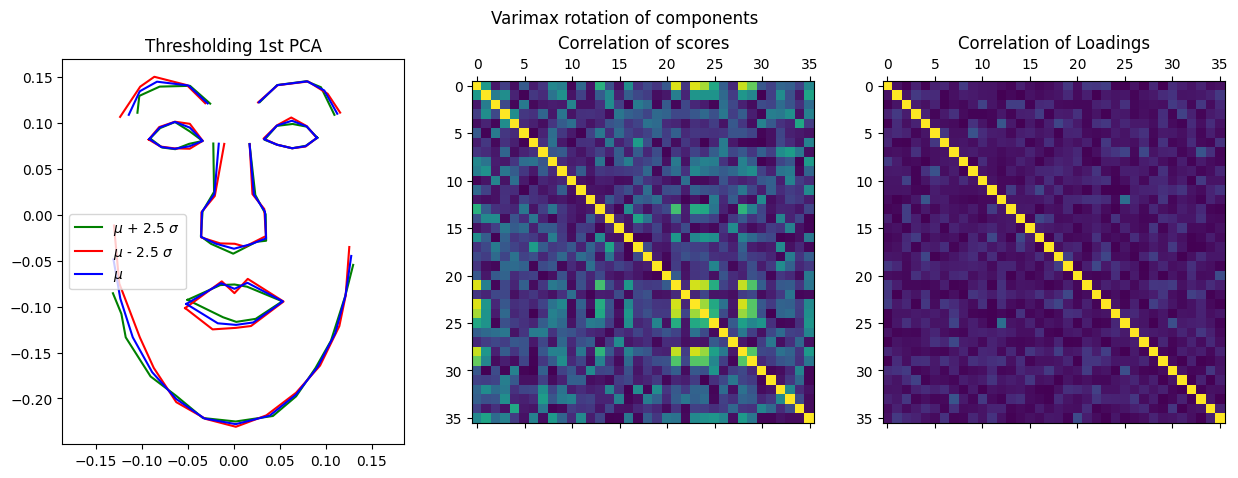

In [10]:
# implement the helper fuction for varimax and use it to find the loadings
""" varimax """
L_varimax = varimax(Lthres, gamma = 1.0, q = 20, tol = 1e-6)
S_varimax = Xc @ L_varimax
sigma2_varimax = np.var(S_varimax, axis = 0)

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("Varimax rotation of components")
drawShapeSubPlot(mu.T + 2.5 * np.sqrt(sigma2_varimax[0]) * L_varimax[:, 0], conlist, ax[0], "$\mu$ + 2.5 $\sigma$", "g")
drawShapeSubPlot(mu.T - 2.5 * np.sqrt(sigma2_varimax[0]) * L_varimax[:, 0], conlist, ax[0], "$\mu$ - 2.5 $\sigma$", "r")
drawShapeSubPlot(mu, conlist, ax[0], "$\mu$", "b")

handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys())
ax[0].set_title("Thresholding 1st PCA")

ax[1].matshow(np.abs(np.corrcoef(S_varimax, rowvar = False)))
ax[1].set_title("Correlation of scores")

ax[2].matshow(np.abs(np.corrcoef(L_varimax, rowvar = False)))
ax[2].set_title("Correlation of Loadings")
fig.show()

> c) Compute the first sparse principal loading vector using the Elastic net (remember to normalize to unit length). Start by using 10 non-zero components. Plot this solution and try different number of nonzero components. Can you put a meaningful
anatomical label on this deformation? Would you be able to label the first mode of variation from regular PCA?

For the elastic net we wish to model the scores as a regression. The important thing is to determine the right amount of non-zero coefficients in the regresssion. To do this we can look at the degrees of freedom. The degrees of freedom in an elastic net i given by:
$$ df = Tr \left( \mathbf{X} \left( \mathbf{X}^{T} \mathbf{X} + \lambda_2 \mathbf{I} \right)^{-1} \mathbf{X}^{T}  \right)$$
, where $\lambda_2$ denotes the regularization weight of the euclidian-norm (So for lasso only $\lambda_2 = 0$). So we need to decide on values of $\alpha$ and l1_ratio such that the degrees of freedom equals the wanted number of non-zero coefficients

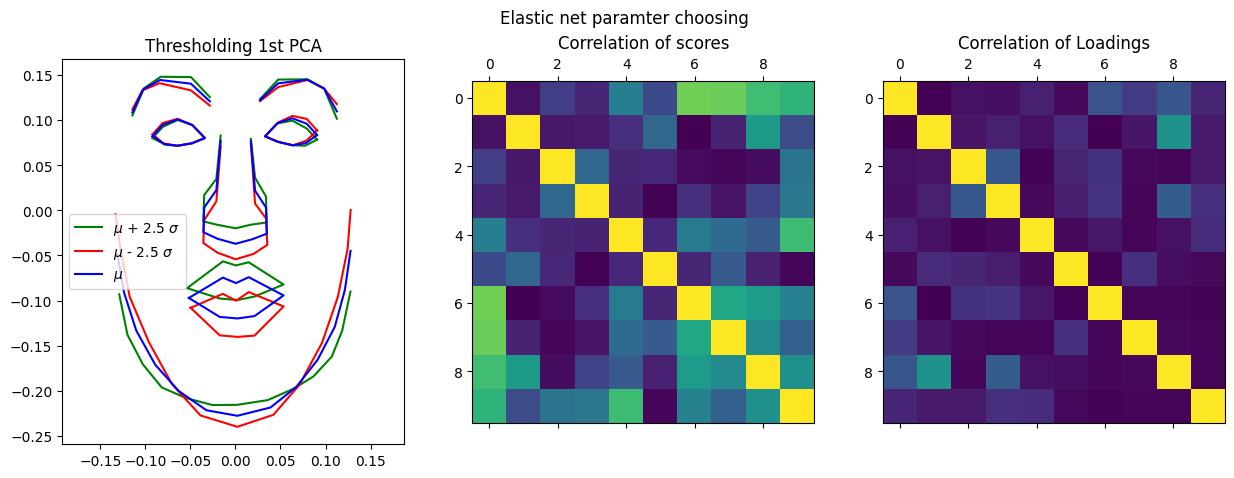

In [11]:
""" Elastic net to choose components """
n_comp = 10 # Use 10 non-zero components

#Determine values for alpha and l1_ratio so df = n_comp
l1 = 0.005 # Decide on l1 ratio
alphas = np.logspace(-4,4,1000) #Define space to search for alpha
lambda2 = alphas * (1 - l1) #Determine l2 norm regularization strength

#Compute degrees of freedom
df = np.zeros(1000)
for i in range(1000):
    inner = np.linalg.inv(Xc.T @ Xc + lambda2[i] * np.eye(p))
    outer = (Xc @ inner) @ Xc.T
    df[i] = np.trace(outer) 
    
idx = np.argmin(np.abs(n_comp-df)) #Determine best match
alpha = alphas[idx] #Decide on alpha value

### IMPLEMENT THE ELASTIC NET HERE
k = 10 # estimate 10 components
L_en = np.zeros((p,k))
ElasticNet = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1, fit_intercept=False)

for i in range(k):
    reg_elastic = ElasticNet.fit(Xc, S[:,i]).coef_
    L_en[:,i] = preprocessing.normalize(reg_elastic.reshape(1, -1), norm = "l2")


S_en = Xc @ L_en # scores (vectors)
sigma2_en = np.var(S_en, axis = 0) # variance of the scores

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("Elastic net paramter choosing")
drawShapeSubPlot(mu.T + 2.5 * np.sqrt(sigma2_en[0]) * L_en[:, 0], conlist, ax[0], "$\mu$ + 2.5 $\sigma$", "g")
drawShapeSubPlot(mu.T - 2.5 * np.sqrt(sigma2_en[0]) * L_en[:, 0], conlist, ax[0], "$\mu$ - 2.5 $\sigma$", "r")
drawShapeSubPlot(mu, conlist, ax[0], "$\mu$", "b")

handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys())
ax[0].set_title("Thresholding 1st PCA")

ax[1].matshow(np.abs(np.corrcoef(S_en, rowvar = False)))
ax[1].set_title("Correlation of scores")

ax[2].matshow(np.abs(np.corrcoef(L_en, rowvar = False)))
ax[2].set_title("Correlation of Loadings")
fig.show()

### Inspect the first 6 modes for the 3 different approaches with the shapeinspector below

> Use the following value to change which approach to use 

>     0 / nothing = PCA
>     1 = Threshold 0.15
>     2 = Verimax
>     3 = Elastic net

Use the sliders in the UI to make the first 6 modes affect the mean face

Make sure that you have the following file structure:


Data:

    -> ShapeInspectorGUI.py
    -> shapeinspector.py
Python:

    -> faces.csv
Matlab

    -> conlist.scv

In [12]:
!python ShapeInspectorGUI.py 1